---
# Named Entity Recognition: Identifying Entities in Text

---

Dveloping and optimizing a Named Entity Recognition (NER) pipeline for identifying and classifying entities in text data. I utilized both **traditional NLP approaches** and **Deep Learning techniques** for comparison and performance analysis.


##### **NER Tags and IOB Format**
NER tag specifying it as one of the following entities. The NER tag follows a special format used widely in NER literature called IOB format(Inside,Outside and Beginning Format).

- **O**: This Tag means the word is not part of the entity
- **B**: This tag means the word is either a single word entity name or else the first word in a multi-word entity name
- **I**: This tag means the word is part of a ulti-word entity but is not the first word in the full entity name

##### **Data Description**

The dataset used in this project is the [Kaggle NER Dataset](https://www.kaggle.com/datasets/namanj27/ner-dataset), a collection of text data annotated with entity types. It consists of a variety of texts, including news articles, social media posts, and other forms of written communication. 
The dataset with 1M x 4 dimensions contains columns = ['# Sentence', 'Word', 'POS', 'Tag'] and is grouped by Sentence #.

**Word**: 
This column contains English dictionary words form the sentence it is taken from.

**POS**: 
This column contains the Parts of speech tag

**Tag**: 
This column contains:

* **Person:** Names of individuals. Eddy Bonte, e,g,. President Obama
* **Location:** Names of geographical entities. e,g,. Murray River, Mount Everest.
* **Organization:** Names of organizations. e,g,. Georgia-Pacific Corp., WHO
* **Date:** Dates and time expressions. e,g,. June, 2008-06-29.
* **Time:** Time expressions. e,g,. two fifty a m, 1:30 p.m.
* **Money:** Monetary values. e,g,. 175 million Canadian Dollars, GBP 10.40.
* **Percentage:** Percentages. e,g,. twenty pct, 18.75 %.
* **GPE:** Geopolitical entities. e,g,. South East Asia, Midlothian.
* **FACILITY:** Legal documents, acts, cases, etc. Washington Monument, Stonehenge


---
## Setup

---

**Import needed dependencies**

In [1]:
import os
import sys
import random
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-white')
%matplotlib inline

**Change Current Working Directory**

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# Change the working directory to a specific path
os.chdir('/mnt/d/ai/WideBotAI')

# Verify the change
current_dir = os.getcwd()
print(f"New working directory: {current_dir}")

if not 'WideBotAI' in sys.path:
    sys.path += ['WideBotAI']

Current working directory: /mnt/d/ai/WideBotAI/NER
New working directory: /mnt/d/ai/WideBotAI


**Setup GPU**

In [6]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


**Set random seed**

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

NameError: name 'torch' is not defined

---
## Import Dataset
---

**Download dataset from kaggle**

Authontcation to access kaggle 

- username:"hebamo7amed"
- key:"dc5470313c833c4962ebace8898816fa"

In [4]:
import opendatasets as od

# Check if the data directory exists
data_dir = './data/ner_dataset.csv'

if os.path.exists(data_dir):
    print("Dataset already exists in the specified directory.")
else:
    # Download the dataset if it doesn't exist
    print("Dataset not found. Downloading...")
    od.download("https://www.kaggle.com/namanj27/ner-dataset")
    print("Dataset downloaded successfully.")

    os.rename('./ner-dataset/ner_datasetreference.csv', os.path.join(data_dir))
    print(f"The dataset has been moved to {data_dir}...")


Dataset already exists in the specified directory.


In [5]:
df = pd.read_csv(data_dir, encoding="latin1")
df[df['Tag'] != 'O']

,Sentence #,Word,POS,Tag
6,NaN,London,NNP,B-geo
12,NaN,Iraq,NNP,B-geo
18,NaN,British,JJ,B-gpe
42,NaN,Bush,NNP,B-per
65,NaN,Hyde,NNP,B-geo
...,...,...,...,...
1048508,NaN,Pakistani,JJ,B-gpe
1048518,NaN,Punjab,NNP,B-geo
1048521,Sentence: 47956,Indian,JJ,B-gpe
1048529,NaN,Saturday,NNP,B-tim


#### Fill NULLs 

Replaces missing values (NaNs) by **forward-filling**. 

In [6]:
df = df.fillna(method='ffill')

### Normalize words

In [7]:
df['Word'] = [w.lower() for w in df['Word']]

---
## Text Mining

---

In [8]:
words = list(set(df['Word'].values))
print("Unique Words in corpus:",df['Word'].nunique())

Unique Words in corpus: 31817


In [9]:
tags = list(set(df['Tag'].values))
print("Unique Tag in corpus:",df['Tag'].nunique())
print(tags)

Unique Tag in corpus: 17
['O', 'I-per', 'B-tim', 'I-art', 'I-gpe', 'I-eve', 'I-geo', 'B-org', 'B-gpe', 'I-org', 'B-nat', 'B-art', 'I-tim', 'B-eve', 'I-nat', 'B-geo', 'B-per']


In [10]:
word_frequencies = {}

# Iterate through the 'Word' column
for word in df['Word']:
    if word in word_frequencies:
        word_frequencies[word] += 1
    else:
        word_frequencies[word] = 1

word_frequencies

{'thousands': 495,
 'of': 26378,
 'demonstrators': 132,
 'have': 5486,
 'marched': 65,
 'through': 518,
 'london': 261,
 'to': 23249,
 'protest': 238,
 'the': 63905,
 'war': 903,
 'in': 28050,
 'iraq': 1738,
 'and': 20116,
 'demand': 221,
 'withdrawal': 154,
 'british': 637,
 'troops': 1202,
 'from': 4557,
 'that': 6437,
 'country': 1934,
 '.': 47771,
 'families': 110,
 'soldiers': 768,
 'killed': 2861,
 'conflict': 245,
 'joined': 116,
 'protesters': 217,
 'who': 1981,
 'carried': 222,
 'banners': 11,
 'with': 5448,
 'such': 423,
 'slogans': 36,
 'as': 4224,
 '"': 3686,
 'bush': 977,
 'number': 463,
 'one': 1692,
 'terrorist': 356,
 'stop': 294,
 'bombings': 243,
 'they': 2397,
 'houses': 57,
 'parliament': 505,
 'a': 22696,
 'rally': 109,
 'hyde': 2,
 'park': 29,
 'police': 1866,
 'put': 183,
 'marchers': 7,
 'at': 4692,
 '10,000': 56,
 'while': 627,
 'organizers': 40,
 'claimed': 282,
 'it': 3823,
 'was': 4881,
 '1,00,000': 36,
 'comes': 234,
 'on': 7113,
 'eve': 53,
 'annual': 138,

In [11]:
InteractiveShell.ast_node_interactivity = "last_expr"

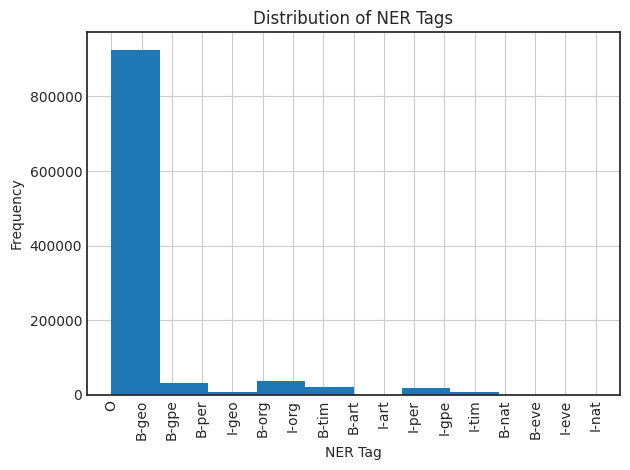

In [12]:
InteractiveShell.ast_node_interactivity = "last_expr"

df["Tag"].hist()
plt.title("Distribution of NER Tags")
plt.xlabel("NER Tag")
plt.ylabel("Frequency")

plt.xticks(rotation=90)  # Rotate labels vertically
plt.tight_layout()  
plt.show()

---
## Baseline Experiments
---

1. **Text Representation:** Text Representation using word-to-vec mapping.
   - Load the pre-trained GloVe embeddings (`glove-twitter-25`) using gensim.downloader.
   - Create a function `get_vector` to handle OOV words by generating random vectors.
   - Apply this function to the `Word` column to create the `WordVector` column.

2. **Data Splitting:**
   - Split the data into training and testing sets (80% for training, 20% for testing).

3. **Model Training:**
   - A Logistic Regression model is used.
   - Train the model on the vectorized training data.

4. **Model Evaluation:**
   - Calculate the accuracy of each model on the test (evaluation) data.
   - Plot the confusion matrices using Seaborn to visualize the model's predictions.
   - Print classification reports to get detailed performance metrics for each tag class.

5. **Make Prediction:** Make predictions on a new unseen words using the trained models.

### 1. Text Representation using word-to-index mapping

In [13]:
import gensim.downloader as api
from gensim.models import KeyedVectors

if os.path.exists("glove-twitter-25"):
    glove_vectors = KeyedVectors.load("glove-twitter-25")
else:
    glove_vectors = api.load("glove-twitter-25")
    glove_vectors.save('glove-twitter-25')

In [14]:
def get_vector(word):
    try:
        return glove_vectors.get_vector(word)
    except KeyError: # Create a random vector for OOV words.
        return np.random.rand(25)  # Generate a random 25-dimensional vector

In [15]:
df["WordVector"] = [get_vector(w) for w in df["Word"]]

for i in range(25):
    df[f"Vector_{i+1}"] = df["WordVector"].apply(lambda x: x[i])

### 2. Data Splitting

In [16]:
X = df.drop(['Sentence #', 'Word', 'POS', 'Tag', 'WordVector'], axis=1).to_numpy()
y = df["Tag"].to_numpy()

In [17]:
import gc

gc.collect()

4545

In [18]:
del df

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (838860, 25)
y_train shape: (838860,)
X_test shape: (209715, 25)
y_test shape: (209715,)


### 3. Model Training

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import time

# 4.1 Logistic Regression Model
start_time = time.time()
model_lr = OneVsRestClassifier(LogisticRegression())
# LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_lr.fit(X_train, y_train)
end_time = time.time()
print(f"Logistic Regression training time: {end_time - start_time:.2f} seconds")

Logistic Regression training time: 42.06 seconds


### 4. Model Evaluation


In [21]:
import utils

y_pred = model_lr.predict(X_test)
lr_results = utils.evaluate_classifier(y_test, y_pred, classes=tags)
lr_results

{'accuracy': 0.8846863600600815,
 'precision': 0.8458690489644326,
 'recall': 0.8846863600600815,
 'f1_score': 0.856315079967204,
 'classification_report': '              precision    recall  f1-score   support\n\n           O       0.91      0.99      0.95    177736\n       I-per       0.56      0.41      0.47      3468\n       B-tim       0.85      0.45      0.59      4037\n       I-art       1.00      0.00      0.00        75\n       I-gpe       1.00      0.00      0.00        42\n       I-eve       1.00      0.00      0.00        53\n       I-geo       0.38      0.00      0.00      1430\n       B-org       0.29      0.02      0.03      4076\n       B-gpe       0.79      0.69      0.73      3186\n       I-org       0.16      0.01      0.01      3201\n       B-nat       0.00      0.00      0.00        38\n       B-art       1.00      0.00      0.00        77\n       I-tim       0.00      0.00      0.00      1374\n       B-eve       1.00      0.00      0.00        60\n       I-nat    

In [22]:
print(lr_results['classification_report'])

              precision    recall  f1-score   support

           O       0.91      0.99      0.95    177736
       I-per       0.56      0.41      0.47      3468
       B-tim       0.85      0.45      0.59      4037
       I-art       1.00      0.00      0.00        75
       I-gpe       1.00      0.00      0.00        42
       I-eve       1.00      0.00      0.00        53
       I-geo       0.38      0.00      0.00      1430
       B-org       0.29      0.02      0.03      4076
       B-gpe       0.79      0.69      0.73      3186
       I-org       0.16      0.01      0.01      3201
       B-nat       0.00      0.00      0.00        38
       B-art       1.00      0.00      0.00        77
       I-tim       0.00      0.00      0.00      1374
       B-eve       1.00      0.00      0.00        60
       I-nat       1.00      0.00      0.00        11
       B-geo       0.56      0.47      0.51      7497
       B-per       0.51      0.30      0.38      3354

    accuracy              

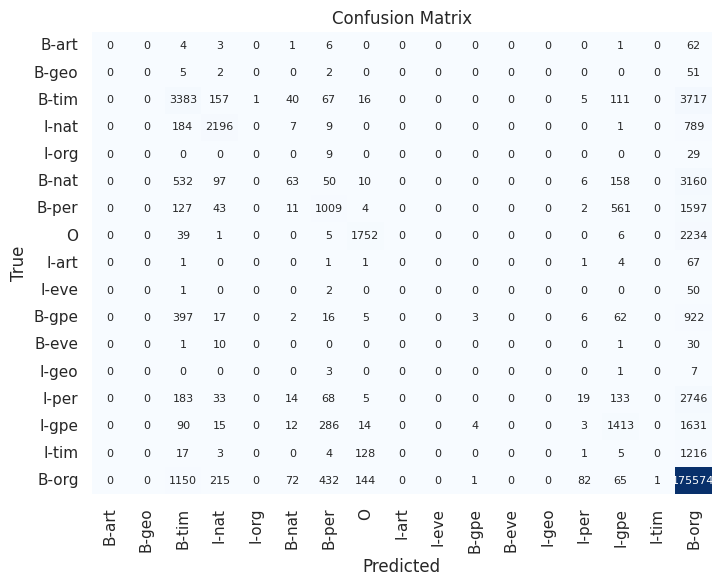

In [24]:
utils.plot_confusion_matrix(y_test, y_pred, classes=tags)

In [ ]:
del X, y, X_train, X_test, y_train, y_test

### 5. Make Prediction

In [133]:
sample_text = "This is Heba and I am doing a demo of the trained NER model using PyTorch through VS Code from Microsoft."
sample_words = sample_text.split()
print(sample_words)

['This', 'is', 'Heba', 'and', 'I', 'am', 'doing', 'a', 'demo', 'of', 'the', 'trained', 'NER', 'model', 'using', 'PyTorch', 'through', 'VS', 'Code', 'from', 'Microsoft.']


In [134]:
preds = []

for w in sample_words:
    vector = get_vector(w)
    pred = model_lr.predict([vector])[0]
    preds.append(pred) 
print(preds)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


---
## LSTM Experiments
---

**LSTMs** are a powerful type of RNN particularly well-suited for tasks involving sequential data like text. It captures long-range dependencies within sequences, allowing the model to understand how words relate to each other across longer distances in a sentence. This capability is crucial for NER, where the context of surrounding words often determines the type of named entity being referred to.

1. **Import dependancies and load dataset.**

2. **Data Preparation:** Preprocess the text data, including tokenization, padding, and encoding words and tags.
    -  Define a custom dataset class to load and prepare your data. It should inherit from `torch.utils.data.Dataset` and implement `__len__` and `__getitem__` methods.
    -  Create a DataLoader to handle batching and shuffling of data.

3. **Data Splitting**: use pytorch random split to split the data into train and test sets.
4. **Model Architecture:** Define the NER model architecture using LSTMs and configure the hyperparameters like the number of LSTM units and embedding dimensionality.
    - Create a class `LSTMModel` that inherits from `nn.Module`. Define the layers (LSTM and fully connected) and the forward pass logic.
    - Set the device (`device`) to "cuda" for GPU usage if available or "cpu" otherwise.
    - Define hyperparameters like input size, hidden size, number of layers, learning rate, batch size, and number of epochs.
    - Create an instance of your `LSTMModel` and move it to the device.
    - Choose an appropriate loss function (e.g., `nn.CrossEntropyLoss` for classification) and an optimizer (e.g., `optim.Adam`).

5. **Model Training:** Train the model on the prepared data, monitoring the performance through loss and accuracy metrics.
    - Iterate through epochs and batches.
    - Perform forward and backward passes.
    - Calculate the loss.
    - Update model weights using the optimizer.
    - Save the trained model's state dictionary using `torch.save`.

6. **Make Prediction:**
    - Load the saved model state dictionary for inference.
    - Use the loaded model to make predictions on new unseen data.

### 1. Import dependancies and load dataset

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [12]:
df = pd.read_csv(data_dir, encoding="latin1")
df = df.fillna(method='ffill')
df.head(5)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


### 2. Data Preparation

Process the data into desired format for fine tuning by separating the data into sentencs and label.

- Groups the data by the "Sentence #" column using `df.groupby(['Sentence #'])`. This ensures processing is done on a sentence-by-sentence basis.
-  Sentences containing a list of tokenized sentences
- Lable containing a list of corresponding IOB
- Along with this there is also a label map dictionary that will map our tags to integres during the fine tuning process

In [71]:
class NERDataset(Dataset):

    def __init__(self, df):
        
        # Create a list of unique words and tags
        self.vocabs = list(set(df["Word"].values))
        self.tags = list(set(df["Tag"].values))
        
        # Create dictionaries for mapping words and tags to integers
        self.word2idx = {w: i+1 for i, w in enumerate(self.vocabs)}
        self.tag2idx = {t: i for i, t in enumerate(self.tags)}

        self.sentences, self.tokens, self.tags = self.word2sent(df)

    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        tags = self.tags[idx][:]
        tokens = self.tokens[idx][:]

        ids = [self.word2idx[token] for token in tokens]
        tags_ids = [self.tag2idx[tag] for tag in tags]

        return {
            'sentences':sentence,
            'tokens': tokens,
            'tags': tags,
            'ids': torch.tensor(ids),
            'tags_ids': torch.tensor(tags_ids),
        }

    def word2sent(self, df):
        sentences  = []
        tokens = []
        tags = []
        groups = df.groupby('Sentence #')

        for i, group in groups:
            words_ = group["Word"].tolist()
            tags_ = group["Tag"].tolist()
            sentences.append(" ".join(words_))
            tokens.append(words_)
            tags.append(tags_)

        return sentences, tokens, tags

In [93]:
dataset = NERDataset(df)
dataset[0]

{'sentences': 'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .',
 'tokens': ['Thousands',
  'of',
  'demonstrators',
  'have',
  'marched',
  'through',
  'London',
  'to',
  'protest',
  'the',
  'war',
  'in',
  'Iraq',
  'and',
  'demand',
  'the',
  'withdrawal',
  'of',
  'British',
  'troops',
  'from',
  'that',
  'country',
  '.'],
 'tags': ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-gpe',
  'O',
  'O',
  'O',
  'O',
  'O'],
 'ids': tensor([10790, 14375, 17904, 16071, 14778, 24777, 12985, 28104, 15776, 17939,
           446,  9415, 35039, 29461, 19573, 17939, 26144, 14375, 29778, 26800,
          6222,  3732, 16567,  1575]),
 'tags_ids': tensor([ 4,  4,  4,  4,  4,  4, 12,  4,  4,  4,  4,  4, 12,  4,  4,  4,  4,  4,
          7,  4,  4,  4,  4,  4])}

### 3. Data Splitting

In [137]:
from torch.utils.data import random_split

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

### 4. Model Architecture

In [95]:
class NERModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.fc(output)
        return output

In [96]:
EMBEDDING_DIM = 32
HIDDEN_DIM = 64
LEARNING_RATE = 0.1
EPOCHS = 10

model_lstm = NERModel(len(dataset.vocabs) + 1, EMBEDDING_DIM, HIDDEN_DIM, len(dataset.tags))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)

### 5. Model Training

In [97]:
def collate_fn(batch):
    x = [item['ids'] for item in batch]
    y = [item['tags_ids'] for item in batch]
    x_lengths = [len(seq) for seq in x]
    y_lengths = [len(seq) for seq in y]
    
    # Pad the sequences to the same length
    x = nn.utils.rnn.pad_sequence(x, batch_first=True)
    y = nn.utils.rnn.pad_sequence(y, batch_first=True)
    
    # Create a mask to ignore padding values in the loss calculation
    x_mask = torch.arange(x.size(1))[None, :] < torch.tensor(x_lengths)[:, None]
    y_mask = torch.arange(y.size(1))[None, :] < torch.tensor(y_lengths)[:, None]
    
    return x, y, x_mask, y_mask

In [98]:
BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,collate_fn = collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,collate_fn = collate_fn)

In [99]:
%%time 
best_val_loss = float('inf')  
patience = 5  
epochs_without_improvement = 0

for epoch in range(EPOCHS):
    
    train_loss = 0.0
    test_loss = 0.0
    model_lstm.train()

    for batch in train_loader:
        x, y, x_mask, y_mask = batch
        optimizer.zero_grad()
        output = model_lstm(x)
        loss = criterion(output.view(-1, len(dataset.tags)), y.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        
    train_loss /= len(train_dataset)
    model_lstm.eval()
    with torch.no_grad():
        for batch in test_loader:
            x, y, x_mask, y_mask = batch
            output = model_lstm(x)
            loss = criterion(output.view(-1, len(dataset.tags)), y.view(-1))
            test_loss += loss.item() * x.size(0)
        test_loss /= len(test_dataset)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f}")

    # Save the model if validation loss improves
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        torch.save(model_lstm.state_dict(), "NER_model.pth")  # Save the model weights
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    
    # Early stopping
    if epochs_without_improvement >= patience:
        print("Early stopping at epoch:", epoch+1)
        break

Epoch 1, Train Loss: 0.2508, Val Loss: 0.2394

Epoch 2, Train Loss: 0.2416, Val Loss: 0.2370

Epoch 3, Train Loss: 0.2337, Val Loss: 0.2322

Epoch 4, Train Loss: 0.2268, Val Loss: 0.2373

Epoch 5, Train Loss: 0.2276, Val Loss: 0.2298

Epoch 6, Train Loss: 0.2198, Val Loss: 0.2262

Epoch 7, Train Loss: 0.2172, Val Loss: 0.2156

Epoch 8, Train Loss: 0.2139, Val Loss: 0.2076

Epoch 9, Train Loss: 0.2118, Val Loss: 0.2136

Epoch 10, Train Loss: 0.2088, Val Loss: 0.2092

CPU times: user 11h 46min 22s, sys: 2h 30min 13s, total: 14h 16min 35s

Wall time: 8h 21min 52s


### 6. Make Prediction

In [106]:
loaded_model = NERModel(len(dataset.vocabs) + 1, EMBEDDING_DIM, HIDDEN_DIM, len(dataset.tags))
loaded_model.load_state_dict(torch.load("NER_model.pth"))

<All keys matched successfully>

In [111]:
text = "This is Heba and I am doing a demo of the trained NER model using PyTorch through VS Code from Microsoft."

# Split the text into words
words = text.split()

# Convert words to numerical values using the word2idx dictionary
x = [dataset.word2idx.get(word, 0) for word in words]

# Convert the numerical values to a tensor and add a batch dimension
x = torch.tensor(x).unsqueeze(0)

# Pass the tensor through the model to get the predicted tags
loaded_model.eval()
with torch.no_grad():
    output = loaded_model(x)
    _, predicted_tags = torch.max(output, dim=2)

# Convert the predicted tags back to their corresponding tag labels using the idx2tag dictionary
predicted_tags = predicted_tags.squeeze().tolist()
predicted_labels = [dataset.tags[idx] for idx in predicted_tags]
print(predicted_labels[0])

NERModel(
  (embedding): Embedding(35178, 32)
  (lstm): LSTM(32, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=47959, bias=True)
)

['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'B-tim', 'O', 'B-geo', 'O', 'B-gpe', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


---
## BERT Experiment
---



In [27]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from datasets import load_dataset, ClassLabel
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

2024-07-21 05:49:58.644286: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 05:49:58.644456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 05:49:58.769341: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 2. Load and Prepare Dataset

In [33]:
df = pd.read_csv(data_dir, encoding="latin1")
df = df.fillna(method='ffill')
df.head(5)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [34]:
from sklearn.preprocessing import LabelEncoder

df['Sentence #'] = LabelEncoder().fit_transform(df['Sentence #'])

Convert dataframe to the following format to fit the expectation of the `simpletransformer` model.

In [35]:
df.rename(columns = {'Sentence #':'sentence_id',
                       'Word':'words',
                       'Tag':'label'},inplace = True)
df

,sentence_id,words,POS,label
0,0,Thousands,NNS,O
1,0,of,IN,O
2,0,demonstrators,NNS,O
3,0,have,VBP,O
4,0,marched,VBN,O
...,...,...,...,...
1048570,42177,they,PRP,O
1048571,42177,responded,VBD,O
1048572,42177,to,TO,O
1048573,42177,the,DT,O


In [36]:
X = df[['sentence_id','words']]
y = df['label']

### 3. Split dataset

In [37]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (838860, 2)
y_train shape: (838860,)
X_test shape: (209715, 2)
y_test shape: (209715,)


In [38]:
train_data = pd.DataFrame({"sentence_id":X_train["sentence_id"],"words":X_train["words"],"labels":y_train})
test_data = pd.DataFrame({"sentence_id":X_test["sentence_id"],"words":X_test["words"],"labels":y_test})

### 3. Fine Tune BERT Model

`NERModel` from `simpletransformers` can expect data in the format of pandas DataFrame with 3 columns. Each sentence should be split into words, with each word assigned a tag, and with all words from the same sentence given the same `sentence_id`.

In [41]:
from simpletransformers.ner import NERModel , NERArgs

args = NERArgs()
args.num_train_epochs = 1
args.learning_rate = 1e-4
args.overwrite_output_dir = True
args.train_batch_size = 4
args.eval_batch_size = 4

In [42]:
model_BERT = NERModel('bert','bert-base-cased',
                      labels = df['label'].unique().tolist() ,
                      use_cuda=torch.cuda.is_available(), 
                      args = args)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [43]:
import time

start_time = time.time()
model_BERT.train_model(train_data , eval_data = test_data , acc = accuracy_score)
end_time = time.time()
print(f"BERT finetuning time: {end_time - start_time:.2f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/11990 [00:00<?, ?it/s]

BERT finetuning time: 1006.59 seconds


### 4. Model Evaluation

In [44]:
result, model_outputs, preds_list = model_BERT.eval_model(test_data)

  0%|          | 0/5 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/11675 [00:00<?, ?it/s]

In [46]:
result

{'eval_loss': 0.18259464129367325,
 'precision': 0.8287187455855347,
 'recall': 0.7541942533907565,
 'f1_score': 0.7897021706208984}

In [48]:
pd.DataFrame(preds_list).to_csv("preds_list")

### 5. Make Prediction

In [49]:
text = "This is Heba and I am doing a demo of the trained NER model using PyTorch through VS Code from Microsoft."

prediction, model_output = model_BERT.predict([text])
prediction

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

[[{'This': 'O'},
  {'is': 'O'},
  {'Heba': 'B-org'},
  {'and': 'O'},
  {'I': 'O'},
  {'am': 'O'},
  {'doing': 'O'},
  {'a': 'O'},
  {'demo': 'O'},
  {'of': 'O'},
  {'the': 'O'},
  {'trained': 'O'},
  {'NER': 'B-org'},
  {'model': 'O'},
  {'using': 'O'},
  {'PyTorch': 'B-org'},
  {'through': 'O'},
  {'VS': 'B-org'},
  {'Code': 'I-org'},
  {'from': 'O'},
  {'Microsoft.': 'B-org'}]]